# Reading Segy Files 

## Importing Tools
### Constant for all files

In [1]:
import random
import os
import sys
import warnings
import datetime





# Helper libraries
import numpy as np
import numpy.matlib
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots


import scipy
from scipy.signal import butter, filtfilt
from scipy.stats import norm
import scipy.io

import segyio

from skimage.metrics import structural_similarity as ssim
# from skimage.measure import compare_ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr



## Play Segy Files

Amplitude Inline range: None - None
Amplitude Crossline range: None - None
None
C01  CLIENT: CGG MCNV  CONTRACTOR: CGG       VESSEL VQH
C02  LINE: HRD_A7739 SEQ000  SHOTS:  PROJECT: NOR0631850001
C03  AREA: NORWAY   DAY-START OF REEL: JULIAN DAY  YEAR
C04  DATA TYPE: VQH SHOT GATHERS FOR SI TESTS 2.5 HZ LC FILTER R7739 PH
C05  ************************* ACQUISITION PARAMETERS
**************************C06  VESSELS: REC.: VIKING VANQUISH;  SRC.: VIKING
VANQUISH                     C07  SOURCE: TYPE: BOLT BROADSOURCE ARRAY; VOL:
4630 CU. IN.; NO.: 2 (1=STBD)   C08   SEPARATION: 37.5M; DEPTH: 6-9M; SHOT INT.:
18.75M FLIP/FLOP              C09  STREAMER: TYPE: SSAS; NO.: 12 (1=STBD);
SEPARATION: 75M; DEPTH: 7-50M      C10   LENGTH: 7950M; GROUPS/STREAMER: 636
(1ST=FRONT); GROUP SEPARATION: 12.5M  C11  RECORDING: SYSTEM: SEAL 428; REC.
LENGTH: 9050MS; SAMPLE INT.: 2MS;        C12  LC FILTER: 2HZ-6DB/OCT; HC FILTER:
200HZ-370DB/OCT; FORMAT: SEG-D 8058 REV1C13  NAVIGATION: SYSTEM: SEAPRONAV;
P

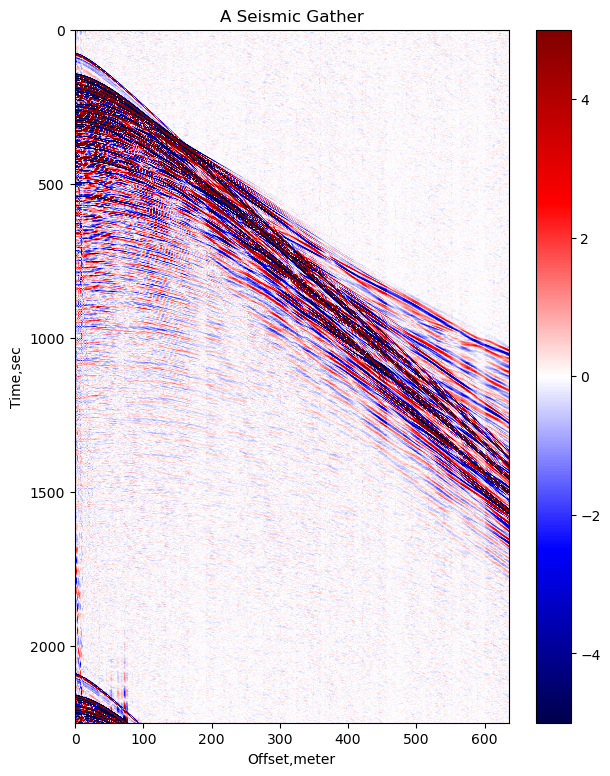

In [3]:

### Reading files and plotting the Seismic data
path = 'C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Sam - Github/Sparse Solver/' 
filename = 'NoSI.segy'
with segyio.open(path+filename, ignore_geometry=True) as f:
    il, xl, t = f.ilines, f.xlines, f.samples
    n_traces = f.tracecount
    print('Amplitude Inline range: ' + str(np.amin(f.ilines)) + ' - ' +str(np.amax(f.ilines))) 
    print('Amplitude Crossline range: ' + str(np.amin(f.xlines)) + ' - ' +str(np.amax(f.xlines)))
    dt=t[1]-t[0]
    print(il)
    d = segyio.tools.collect(f.trace[:])
    n_samples=d.shape[1]

#Checking the headers
f = segyio.open(path+filename, ignore_geometry=True) 
segyio.tools.wrap(f.text[0])
print(segyio.tools.wrap(f.text[0]))


print(f'dt=',dt,f'n_traces=',n_traces,f'n_sample=',n_samples)
plt.figure(figsize=(7, 9))
plt.imshow(d.T, cmap='seismic', vmin=-5, vmax=5)
plt.title('A Seismic Gather')
plt.colorbar()
plt.xlabel(f'Offset,meter')
plt.ylabel(f'Time,sec')
plt.axis('tight');
print(d.shape)

    
    

In [51]:
fk = np.fft.rfft2(d)

fs=500
dx=6.25
f_max=50
f_min=20
v_max= 50000
# determines slowness resolution (should be high number) 
Nyq_f = fs/2
Nyq_k = (1/(2*dx))
size_f,size_k = fk.shape

freq_vec = np.linspace(0,200,fk.shape[1])
df = np.min(np.diff(freq_vec))
k_vec = np.linspace(-Nyq_k,Nyq_k,fk.shape[0])
dk = np.min(np.diff(k_vec))


ind_fmax = np.argwhere(freq_vec<=f_max)
ind_fmax = np.max(ind_fmax)
f_max = freq_vec[ind_fmax]

ind_fmin = np.argwhere(freq_vec<=f_min)
ind_fmin = np.min(ind_fmin)
f_min = freq_vec[ind_fmin]

s_max =    0.1*np.max(abs(k_vec))  #np.max(abs(k_vec))/f_max   #
s_min = - s_max
s_resolution = 1/v_max


f_vec = freq_vec[ind_fmin:ind_fmax]
s_vec = np.arange(start=s_min,step=s_resolution,stop=s_max)
#s_vec = np.linspace(s_min,s_max,fk.shape[0])
ds=np.min(np.diff(s_vec))
slowness_f = np.zeros((len(s_vec),len(f_vec)))

for fi in range(0,len(f_vec),1):
    for si in range (0,len(s_vec),1):
        
        ind_f = np.argwhere(freq_vec>=f_vec[fi])
        ind_f = np.min(ind_f)

        k = s_vec[si]*f_vec[fi]

        ind_k = np.argwhere(k_vec>=k)

        if len(ind_k) == 0:
            #print(f'if',ind_k,ind_f)
            slowness_f[si,fi] = fk[0,ind_f]
        else: 
            ind_k = np.min(ind_k)
            #print(ind_k)
            slowness_f[si,fi] = fk[ind_k,ind_f]
print(slowness_f.shape)



C:\Users\Ssach\AppData\Local\Temp\ipykernel_19012\2068473141.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  slowness_f[si,fi] = fk[ind_k,ind_f]
C:\Users\Ssach\AppData\Local\Temp\ipykernel_19012\2068473141.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  slowness_f[si,fi] = fk[0,ind_f]


(800, 281)


(800, 281)


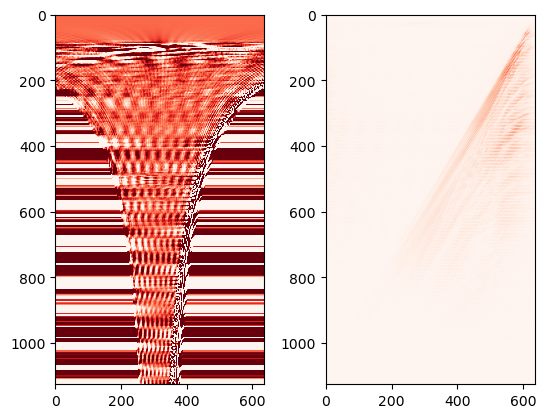

In [52]:
print(slowness_f.shape)
plt.figure(dpi=100)
plt.subplot(121)
plt.imshow((slowness_f).T,cmap='Reds',vmax=1000,vmin=-1000,extent=[0,636,1126,0])
plt.subplot(122)
plt.imshow(np.abs(fk).T,cmap='Reds',)


C:\Users\Ssach\AppData\Local\Temp\ipykernel_19496\2962244373.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  slowness_f[si,fi] = fk_filtered[ind_k,ind_f]


(636, 1125)


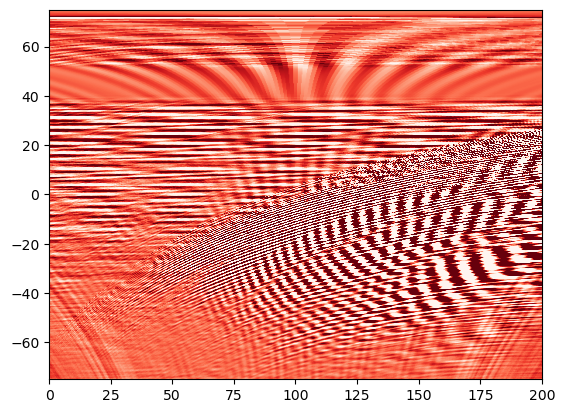

In [47]:

flp=30
fhi=50
(f._samples,f._xlines) = butter(5,[flp/200,fhi/200],'stop')
d_filtered = filtfilt(f._samples,f._xlines,d)
fk_filtered = np.fft.rfft2(d_filtered)

fs=250
dx=75
f_max=200
f_min=0
v_max= 500000
# determines slowness resolution (should be high number) 
Nyq_f = fs/2
Nyq_k = (1/(2*dx))
size_f,size_k = fk_filtered.shape

freq_vec = np.linspace(0,200,fk_filtered.shape[1])
df = np.min(np.diff(freq_vec))
k_vec = np.linspace(-Nyq_k,Nyq_k,fk_filtered.shape[0])
dk = np.min(np.diff(k_vec))


ind_fmax = np.argwhere(freq_vec<=f_max)
ind_fmax = np.max(ind_fmax)
f_max = freq_vec[ind_fmax]

ind_fmin = np.argwhere(freq_vec<=f_min)
ind_fmin = np.min(ind_fmin)
f_min = freq_vec[ind_fmin]

s_max = np.max(abs(k_vec))/f_max #0.1*np.max(abs(k_vec))#  
s_min = - s_max
s_resolution = 1/v_max


f_vec = freq_vec[ind_fmin:ind_fmax]
#s_vec = np.arange(start=s_min,step=s_resolution,stop=s_max)
s_vec = np.linspace(s_min,s_max,fk.shape[0])
ds=np.min(np.diff(s_vec))
slowness_f = np.zeros((len(s_vec),len(f_vec)))

for fi in range(0,len(f_vec),1):
    for si in range (0,len(s_vec),1):
        
        ind_f = np.argwhere(freq_vec>=f_vec[fi])
        ind_f = np.min(ind_f)

        k = s_vec[si]*f_vec[fi]

        ind_k = np.argwhere(k_vec>=k)

        if len(ind_k) == 0:
            #print(f'if',ind_k,ind_f)
            slowness_f[si,fi] = fk_filtered[0,ind_f]
        else: 
            ind_k = np.min(ind_k)
            #print(ind_k)
            slowness_f[si,fi] = fk_filtered[ind_k,ind_f]
print(slowness_f.shape)
plt.imshow(slowness_f.T,cmap='Reds',vmax=1000,vmin=-1000,extent=[0,200,-75,75])



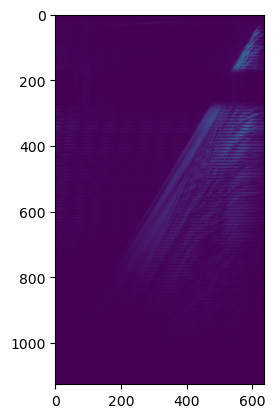

In [48]:
plt.imshow(np.abs(fk_filtered).T)

### RADON Transform

(636, 2251) (636, 180)


Text(0.5, 1.0, '(tau-p) to (tau_f - p):Radon+FFT')

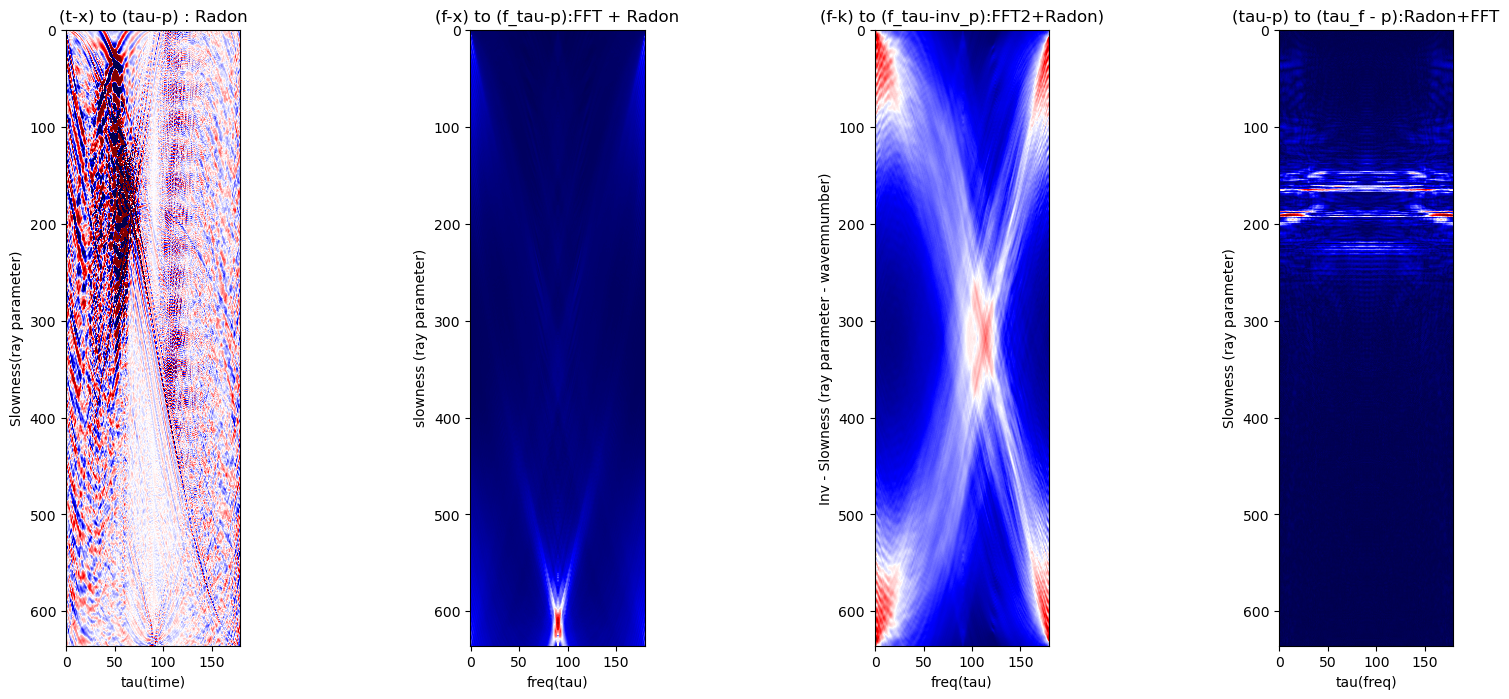

In [39]:
from scipy import signal
from skimage.transform import radon, iradon




FFT = np.abs(np.fft.fft(d)) 
FFT2 = np.abs(np.fft.fft2(d)) 
Radon= radon(d) 
Radon_FFT = radon(FFT)
Radon_FFT2 = radon(FFT2)
FFT_Radon = np.fft.fft(Radon)
print(d.shape,Radon.shape)


plt.figure(figsize=(20,8))

plt.subplot(141)
plt.imshow((Radon),cmap='seismic',vmax=100,vmin=-100)

plt.xlabel('tau(time)')
plt.ylabel('Slowness(ray parameter)')
plt.title('(t-x) to (tau-p) : Radon')


plt.subplot(142)
plt.imshow((Radon_FFT),cmap='seismic')

plt.xlabel('freq(tau)')
plt.ylabel('slowness (ray parameter)')
plt.title('(f-x) to (f_tau-p):FFT + Radon')


plt.subplot(143)
plt.imshow((Radon_FFT2),cmap='seismic')

plt.xlabel('freq(tau)')
plt.ylabel('Inv - Slowness (ray parameter - wavemnumber)')
plt.title('(f-k) to (f_tau-inv_p):FFT2+Radon)')

plt.subplot(144)
plt.imshow(np.abs(FFT_Radon),cmap='seismic')

plt.xlabel('tau(freq)')
plt.ylabel('Slowness (ray parameter)')
plt.title('(tau-p) to (tau_f - p):Radon+FFT')


#plt.pcolormesh(f,t,np.abs(Zxx),vmin=0,vmax=100,shading='gouraud')
#plt.show


### Frequency Spectrum

In [72]:
fs=1000/4
t = np.arange(0,9,1/fs)
fft=np.fft.fft(d)
X = np.fft.fft(d)
N=len(fft)
n=np.arange(N)
T=N/fs
freq=n/T
FT = np.linspace(-200,(200-(fs/9),fs/9))
fft_freq = np.fft.fftfreq(2251,0.004)
y=np.abs(np.fft.fftshift(fft))


flp=30
fhi=50
(f._samples,f._xlines) = butter(5,[flp/200,fhi/200],'stop')
d_filtered = filtfilt(f._samples,f._xlines,d)
fft_filtered=np.fft.fft(d_filtered)

d_remainig = d-d_filtered
print(len(t))

plt.figure(figsize=(17,7))
plt.subplot(1,3,1)
plt.imshow(np.abs(fft).T)
plt.subplot(1,3,2)
plt.imshow(np.abs(fft_filtered).T)
plt.subplot(1,3,3)
plt.plot(freq,np.abs(d))




AttributeError: 'numpy.ndarray' object has no attribute 'samples'

## Understanding - Fourier transforms

"plt.subplot(1,5,3)\nplt.imshow(phase.T,cmap='seismic', vmin=0, vmax=10)\nplt.title('FFT2-Phase spectrum')\nplt.xlabel(f'offset')\n\nplt.axis('tight');\n\nplt.subplot(1,5,4)\nplt.imshow((amp_restored).T,cmap='seismic', vmin=-10, vmax=10)\nplt.title('IFFT2 - with magnitude only')\nplt.xlabel(f'offset')\n\nplt.axis('tight');\n\nplt.subplot(1,5,5)\nplt.imshow((phase_restored).T,cmap='seismic', vmin=-0.01, vmax=0.01)\nplt.title('IFFT2 - with phase only')\nplt.xlabel(f'offset')\n\nplt.axis('tight');"

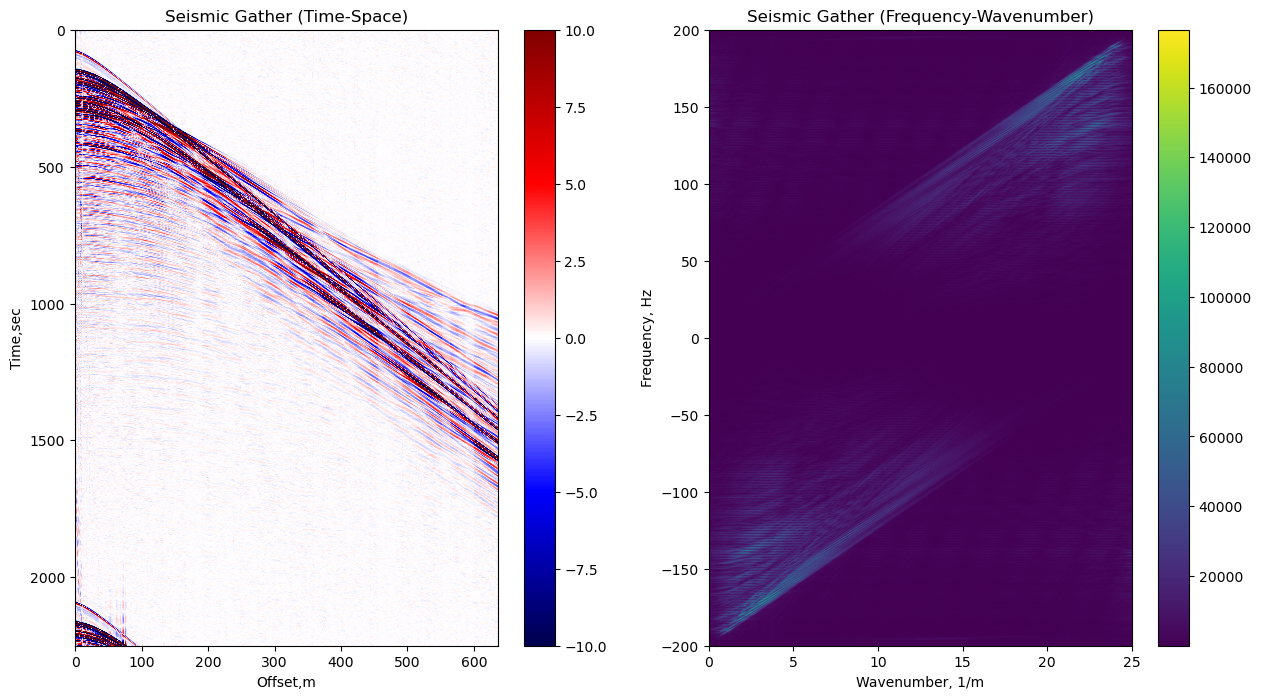

In [68]:
##  data spectrum
fs = 1000/dt
amp = (np.abs(np.fft.fft2(d)))
re = np.fft.fft2(d)
amp_log = np.log(np.abs(amp))
amp_restored = np.abs((np.fft.ifft2(re)))
amp_power = np.abs(amp)**2

## Plotting Phase spectrum
phase = np.abs(np.angle(re))
phase_restored = np.abs(np.fft.ifft2(phase))

## Trimiing the spectrum due to symmterical features of the fft2
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(d.T, cmap='seismic', vmin=-10, vmax=10)
plt.colorbar()
plt.title('Seismic Gather (Time-Space)')
plt.xlabel(f'Offset,m')
plt.ylabel(f'Time,sec')
plt.axis('tight');


plt.subplot(1,2,2)
plt.imshow(amp.T,extent=[0,25,-200,200])
plt.colorbar()
plt.title('Seismic Gather (Frequency-Wavenumber)')
plt.xlabel(f'Wavenumber, 1/m')
plt.ylabel(f'Frequency, Hz')
plt.axis('tight');


'''plt.subplot(1,5,3)
plt.imshow(phase.T,cmap='seismic', vmin=0, vmax=10)
plt.title('FFT2-Phase spectrum')
plt.xlabel(f'offset')

plt.axis('tight');

plt.subplot(1,5,4)
plt.imshow((amp_restored).T,cmap='seismic', vmin=-10, vmax=10)
plt.title('IFFT2 - with magnitude only')
plt.xlabel(f'offset')

plt.axis('tight');

plt.subplot(1,5,5)
plt.imshow((phase_restored).T,cmap='seismic', vmin=-0.01, vmax=0.01)
plt.title('IFFT2 - with phase only')
plt.xlabel(f'offset')

plt.axis('tight');'''

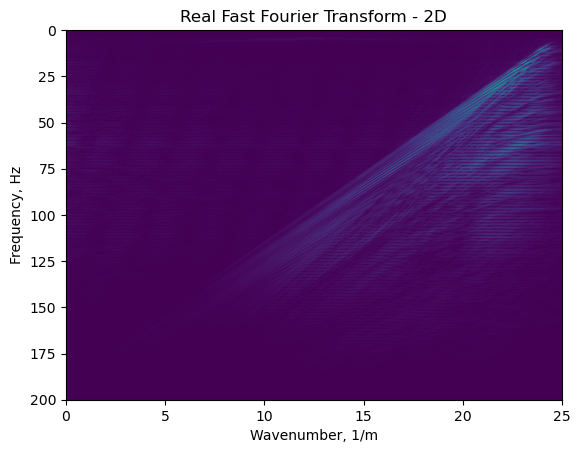

In [24]:
forward = np.fft.rfft2(d) 
backward = np.fft.irfft2(forward)
plt.imshow(np.abs(forward).T,extent=[0,25,200,0])
plt.title('Real Fast Fourier Transform - 2D')
plt.xlabel(f'Wavenumber, 1/m')
plt.ylabel(f'Frequency, Hz')
plt.axis('tight');

In [7]:
'''##  Fourier shift with log scale
fs = 1000/dt
f1=np.fft.fft2(d)
mag1=abs(f1)
s=np.fft.fftshift(f1)
phase1=np.angle(f1)

r1 = (np.fft.ifft2(np.fft.ifftshift(mag1)))
r2 = np.fft.ifft2((d*phase1))
plt.figure(figsize=(13,15))
plt.subplot(1,4,1)
plt.imshow(d.T,cmap='seismic',vmax=10,vmin=0)
plt.subplot(1,4,2)
plt.imshow(abs(s).T)
plt.subplot(1,4,3)
plt.imshow(abs(r1).T,cmap='seismic',vmax=50,vmin=0)
plt.subplot(1,4,4)
plt.imshow(abs(r2).T)'''

"##  Fourier shift with log scale\nfs = 1000/dt\nf1=np.fft.fft2(d)\nmag1=abs(f1)\ns=np.fft.fftshift(f1)\nphase1=np.angle(f1)\n\nr1 = (np.fft.ifft2(np.fft.ifftshift(mag1)))\nr2 = np.fft.ifft2((d*phase1))\nplt.figure(figsize=(13,15))\nplt.subplot(1,4,1)\nplt.imshow(d.T,cmap='seismic',vmax=10,vmin=0)\nplt.subplot(1,4,2)\nplt.imshow(abs(s).T)\nplt.subplot(1,4,3)\nplt.imshow(abs(r1).T,cmap='seismic',vmax=50,vmin=0)\nplt.subplot(1,4,4)\nplt.imshow(abs(r2).T)"

Text(0.5, 1.0, 'IRFFT2 - with phase only')

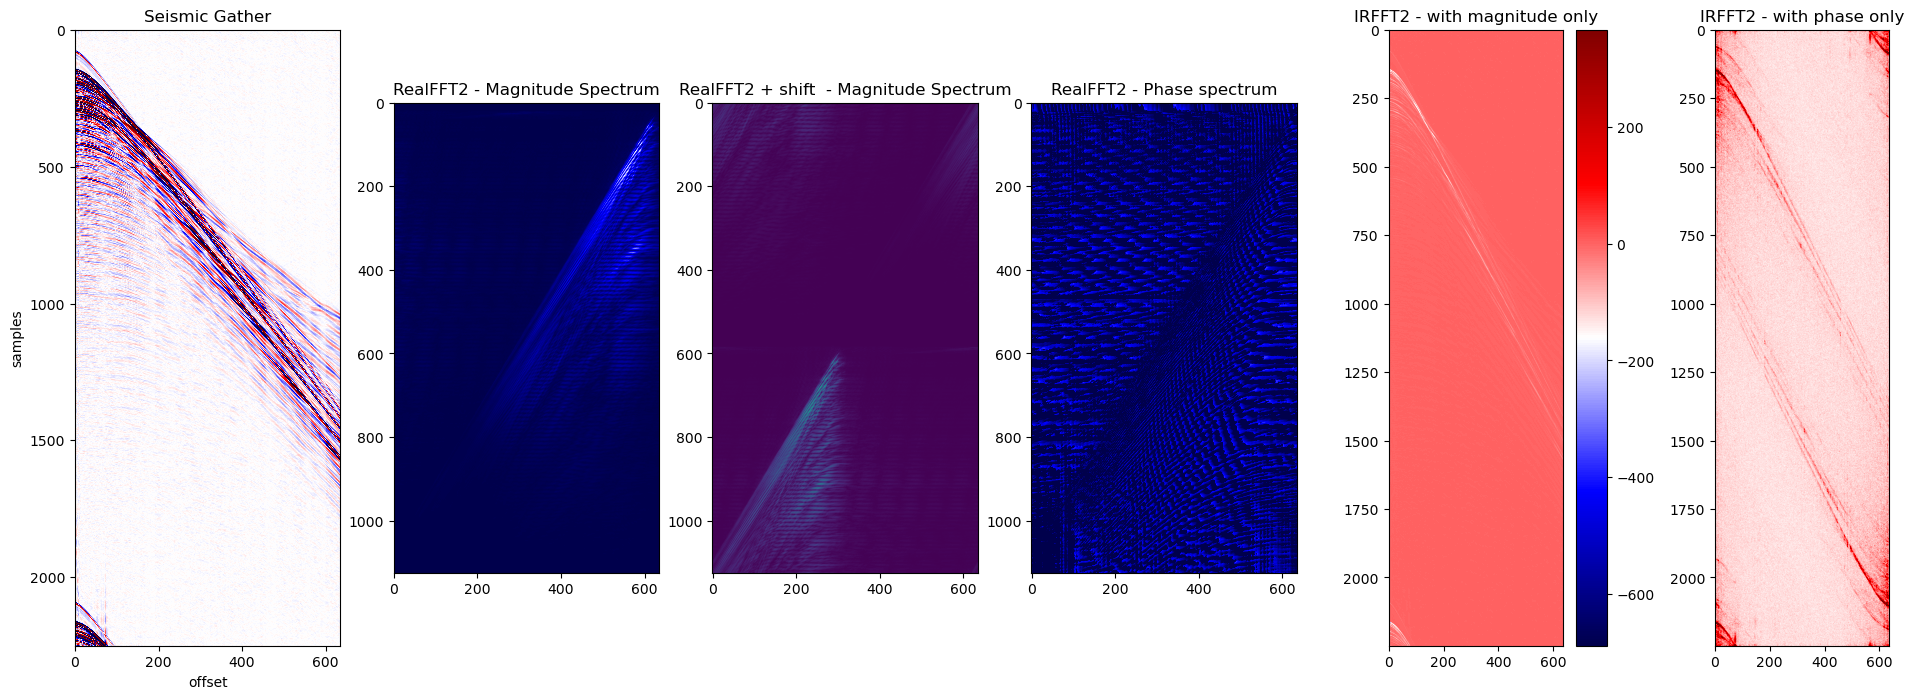

In [38]:
## Real-fft
amp = np.fft.rfft2(d)
amp_abs = np.abs(amp)
amp_shift = np.abs(np.fft.fftshift(amp))
amp_abs_shift = np.abs(amp_shift)

phase = np.angle(amp)


restore_amp = (np.fft.irfft2(amp))
restore_shift = np.abs(np.fft.irfft2(np.fft.ifftshift(amp_shift)))
restore_phase = np.abs(np.fft.irfft2(phase))

## Trimiing the spectrum due to symmterical features of the fft2


plt.figure(figsize=(24,8))
plt.subplot(1,6,1)
plt.imshow(d.T, cmap='seismic', vmin=-10, vmax=10)
plt.title('Seismic Gather')
plt.xlabel(f'offset')
plt.ylabel(f'samples')
plt.axis('tight')

plt.subplot(1,6,2)
plt.imshow(amp_abs.T, cmap='seismic')
plt.title('RealFFT2 - Magnitude Spectrum')


plt.subplot(1,6,3)
plt.imshow(amp_abs_shift.T)
plt.title('RealFFT2 + shift  - Magnitude Spectrum')


plt.subplot(1,6,4)
plt.imshow(phase.T,cmap='seismic', vmin=0, vmax=10)
plt.title('RealFFT2 - Phase spectrum')

plt.subplot(1,6,5)
plt.imshow((d[0:636,0:2250] - np.abs(restore_amp)).T,cmap='seismic')
plt.title('IRFFT2 - with magnitude only')
plt.colorbar()

plt.subplot(1,6,6)
plt.imshow((restore_phase).T,cmap='seismic',vmin=-0.01, vmax=0.01)
plt.title('IRFFT2 - with phase only')

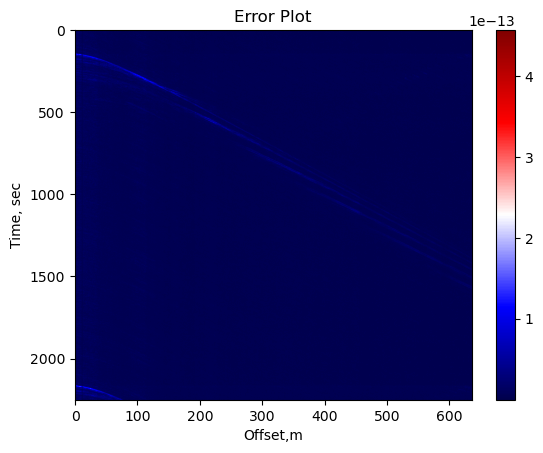

In [66]:
error =  d - np.fft.ifft2(np.fft.fft2(d))
plt.figure(dpi=100)
plt.imshow(np.abs(error).T,cmap='seismic')
plt.title('Error Plot')
plt.colorbar()
plt.xlabel(f'Offset,m')
plt.ylabel(f'Time, sec')
plt.axis('tight');

## Apllying Frequency band to gather


In [67]:
##### Plotting Filtered data and its Real FFT
flp=30
fhi=50
(f._samples,f._xlines) = butter(5,[flp/200,fhi/200],'stop')
d_filtered = filtfilt(f._samples,f._xlines,d)


d_filtered_rfft = (np.fft.rfft2(d_filtered))
d_filtered_rfftshift = np.abs(np.fft.fftshift(d_filtered_rfft))
d_filtered_mag = np.abs(d_filtered_rfft)
d_filtered_phase = np.angle(d_filtered_rfft)

restore_d_filtered = np.abs(np.fft.irfft2(d_filtered_rfft))
restore_d_phase = np.abs(np.fft.ifft2(d_filtered_phase))

plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
plt.imshow(d_filtered.T, cmap='seismic', vmin=-5, vmax=5)
plt.title('Filtered Seismic data')

plt.subplot(1,4,2)
plt.imshow(d_filtered_mag.T, cmap='seismic',extent=[0,25,200,0])
plt.xlabel('wavenumber (1/cm)')
plt.ylabel('Frequency (Hz)')
plt.title('Filtered RFFT')


plt.subplot(1,4,3)
plt.imshow((d[0:636,0:2250]- restore_d_filtered).T,cmap='seismic', vmin=-5, vmax=5)
plt.title('Restored Filtered RFFT')
plt.colorbar()

plt.subplot(1,4,4)
plt.imshow(restore_d_phase.T,cmap='seismic',vmin=-0.01, vmax=0.01)
plt.title('Phase Restored Filtered RFFT')



AttributeError: 'numpy.ndarray' object has no attribute '_samples'

In [42]:
print(d.shape)
print(d_filtered.shape)
print(d_filtered_mag.shape)


(636, 2251)
(636, 2251)
(636, 1126)


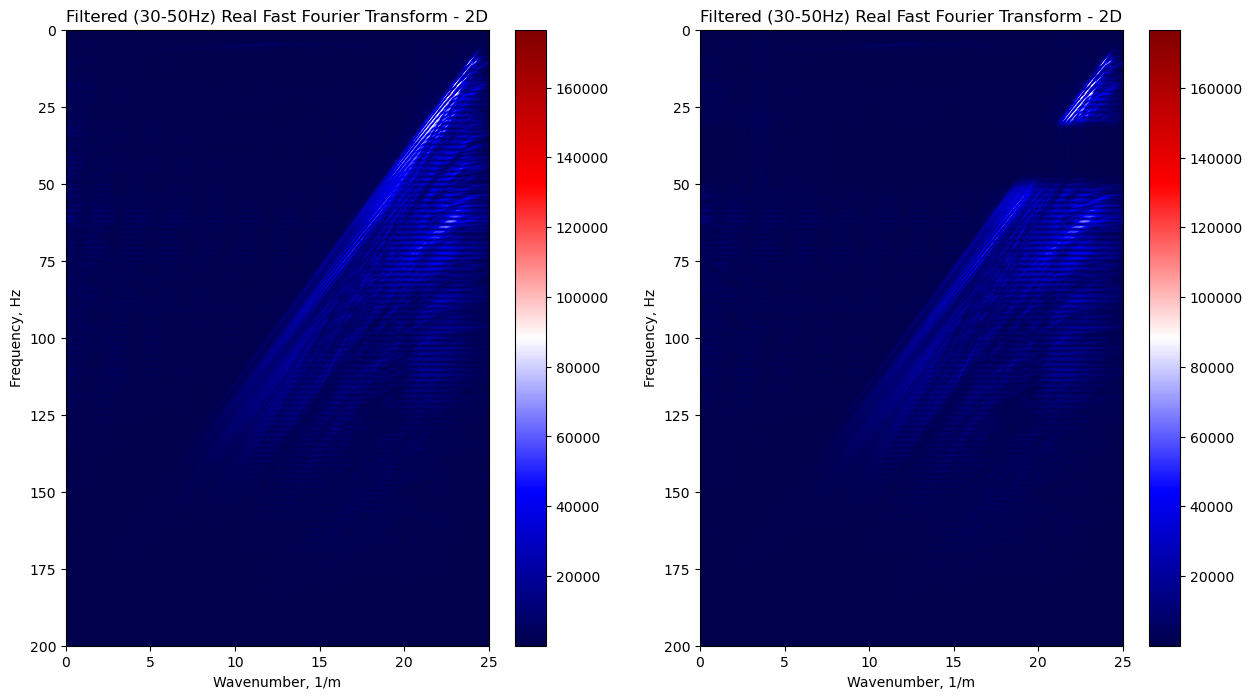

In [43]:

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(np.abs(forward).T, cmap='seismic',extent=[0,25,200,0])
plt.colorbar()
plt.title('Filtered (30-50Hz) Real Fast Fourier Transform - 2D')
plt.xlabel(f'Wavenumber, 1/m')
plt.ylabel(f'Frequency, Hz')
plt.axis('tight');
plt.subplot(1,2,2)
plt.imshow(np.abs(d_filtered_rfft).T, cmap='seismic',extent=[0,25,200,0])
plt.colorbar()
plt.title('Filtered (30-50Hz) Real Fast Fourier Transform - 2D')
plt.xlabel(f'Wavenumber, 1/m')
plt.ylabel(f'Frequency, Hz')
plt.axis('tight');

Text(0.5, 1.0, 'Freq spectrum - Filtered RFFT')

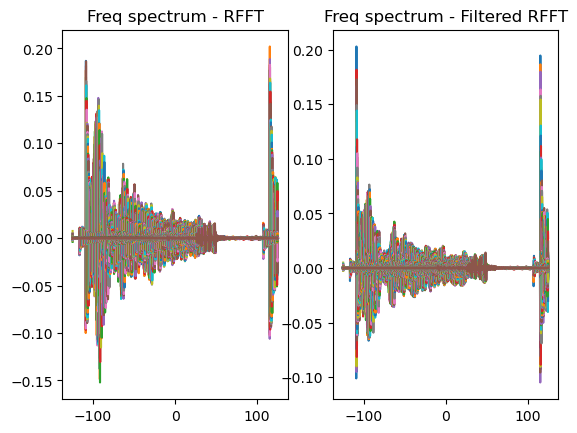

In [19]:
### Frequency spectrum 
d_filtered_rfft = np.abs(np.fft.rfft2(d_filtered))
d_rfft = np.abs(np.fft.rfft2(d))


fs=1/dt
df = (fs/n_samples)
f = np.arange(-fs/2,fs/2,df)
stop_time =  9.050
t = np.arange(0,stop_time-dt,dt)
N= np.shape(t)

plt.subplot(1,2,1)
plt.plot(f,d.T/N)
plt.title('Freq spectrum - RFFT')
plt.subplot(1,2,2)
plt.plot(f,d_filtered.T/N)
plt.title('Freq spectrum - Filtered RFFT')

In [46]:
with segyio.open(path+filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)

f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms, Trace length: {max(twt)}'

'N Traces: 636, N Samples: 2251, Sample rate: 4.0ms, Trace length: 9000.0'

In [ ]:
flp=30
fhi=50
with segyio.open(path + filename, ignore_geometry=True) as f:
    gather = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[ini_time:end_time,1+1*(635) : 1+(1+1)*(635)]
(f._samples,f._xlines) = butter(5,[flp/200,fhi/200],'stop')
d_filtered = filtfilt(f._samples,f._xlines,gather[0:256,0:64])

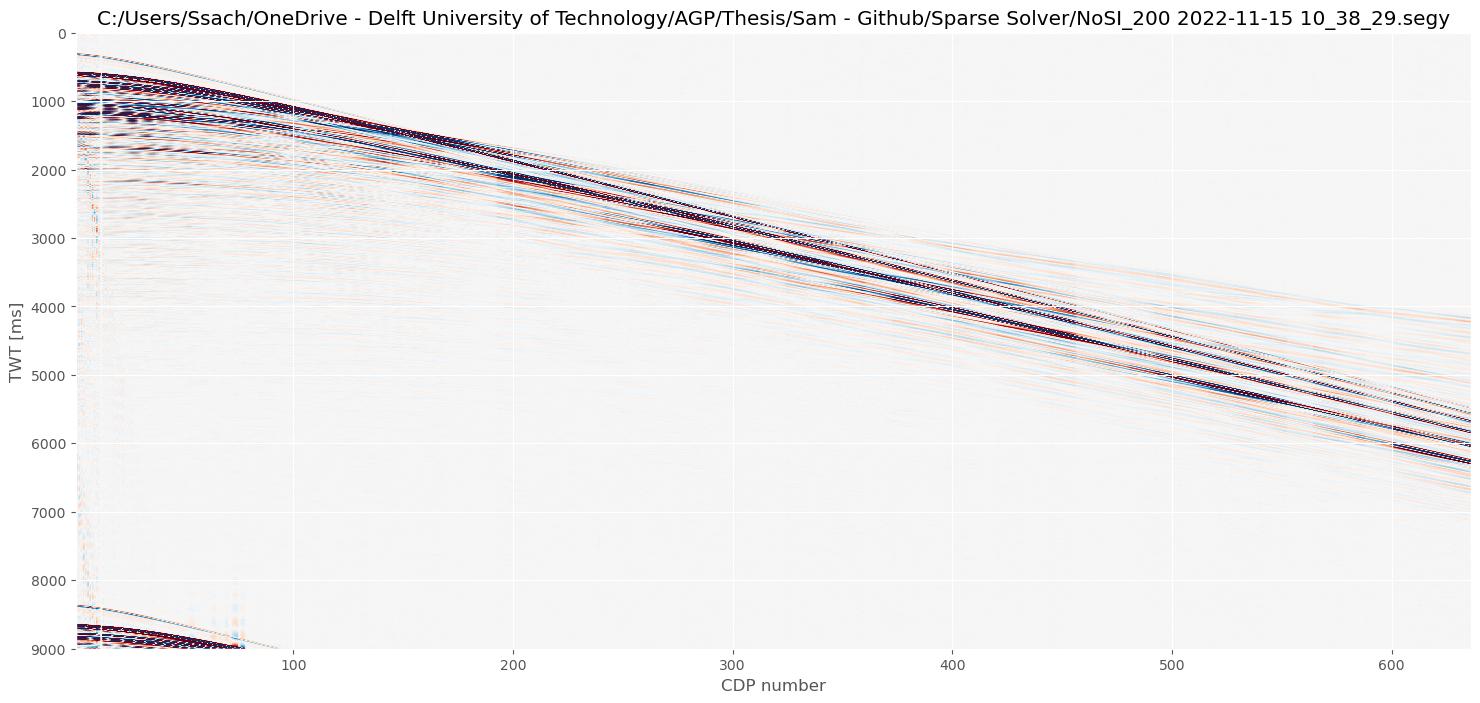

In [47]:
def plot_segy(file):
    # Load data
    with segyio.open(file, ignore_geometry=True) as f:
        # Get basic attributes
        n_traces = f.tracecount
        sample_rate = segyio.tools.dt(f) / 1000
        n_samples = f.samples.size
        twt = f.samples
        data = f.trace.raw[:]
    # Plot
    plt.style.use('ggplot')  # Use ggplot styles for all plotting
    vm = np.percentile(data, 99)
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(1, 1, 1)
    extent = [1, n_traces, twt[-1], twt[0]]  # define extent
    ax.imshow(data.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
    ax.set_xlabel('CDP number')
    ax.set_ylabel('TWT [ms]')
    ax.set_title(f'{file}')
plot_segy(path+filename)

In [21]:
## Filter function
def myStrongFilter(data,flp,fhi,delt):
    #data - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    flp = flp/2
    fhi = fhi/2
    
    Fs = 1/delt
    Nyq = Nyq = Fs/2
    
    Data_Freq = fft(data,axis=0)
    Filter = np.ones(Data_Freq.shape)
    Filter[int(np.ceil((flp/Nyq)*Data_Freq.shape[0])):int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])),:] = 0
    Filter[-int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])):-int(np.ceil((flp/Nyq)*Data_Freq.shape[0])),:] = 0

    Data_Freq_Filt = Data_Freq*Filter
    
    return np.real(ifft(Data_Freq_Filt,axis=0))

Text(0.5, 1.0, 'Phase Restored Filtered RFFT')

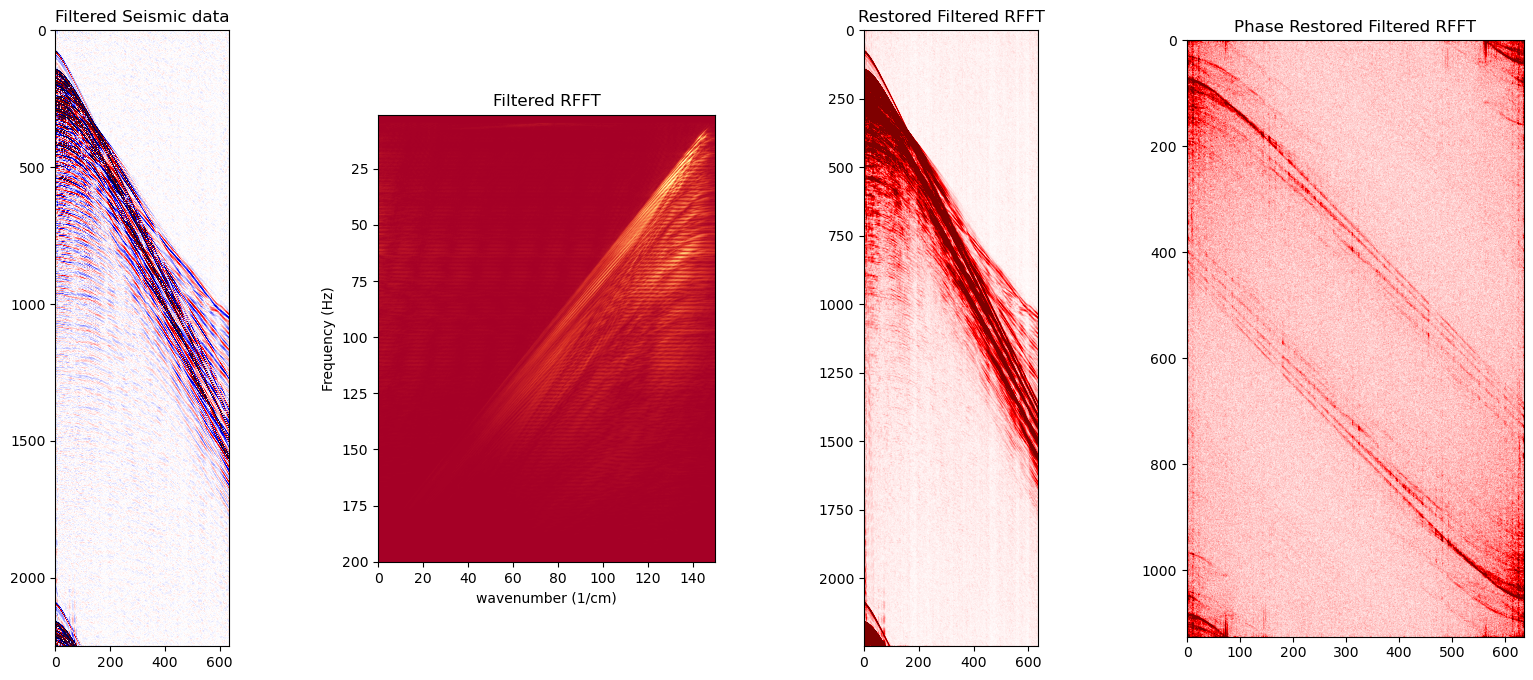

In [29]:
flp=20
fhi=50
#(f._samples,f._xlines) = butter(5,[flp/200,fhi/200],'stop')
d_filtered = myStrongFilter(d,flp,fhi,dt)


d_filtered_rfft = (np.fft.rfft2(d_filtered))
d_filtered_rfftshift = np.abs(np.fft.fftshift(d_filtered_rfft))
d_filtered_mag = np.abs(d_filtered_rfft)
d_filtered_phase = np.angle(d_filtered_rfft)

restore_d_filtered = np.abs(np.fft.irfft2(d_filtered_rfft))
restore_d_phase = np.abs(np.fft.ifft2(d_filtered_phase))

plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
plt.imshow(d_filtered.T, cmap='seismic', vmin=-5, vmax=5)
plt.title('Filtered Seismic data')

plt.subplot(1,4,2)
plt.imshow(d_filtered_mag.T, cmap='RdYlGn',extent=[0,150,200,1])
plt.xlabel('wavenumber (1/cm)')
plt.ylabel('Frequency (Hz)')
plt.title('Filtered RFFT')


plt.subplot(1,4,3)
plt.imshow(restore_d_filtered.T,cmap='seismic', vmin=-5, vmax=5)
plt.title('Restored Filtered RFFT')

plt.subplot(1,4,4)
plt.imshow(restore_d_phase.T,cmap='seismic',vmin=-0.01, vmax=0.01)
plt.title('Phase Restored Filtered RFFT')

(636, 2251)
(636, 2251)
(636, 1126)


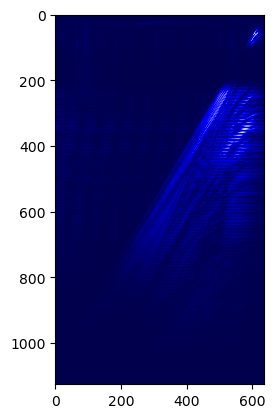

In [32]:
with segyio.open(path + filename, ignore_geometry=True) as f:
    gather  = segyio.tools.collect(f.trace[0:636,0:2251])
    print(gather.shape)
    window=gather
    (f._samples,f._xlines) = butter(5,[flp/250,fhi/250],'stop')

    filtered_train = filtfilt(f._samples,f._xlines,gather)
    fk_train =np.abs(np.fft.rfft2(window))
    inv_fk_train = (np.fft.irfft2(fk_train))

    fk_filt_train = np.abs(np.fft.rfft2(filtered_train))
    inv_fk_filt_train =(np.fft.irfft2(fk_filt_train))

   
    plt.imshow(fk_filt_train.T,cmap='seismic')
    print(filtered_train.shape)
    print(fk_filt_train.shape)
    